
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.02348235 -0.14816733  0.04858244  0.34051964] 0 1.0 False {}
state, action, reward, done, info
[0.020519   0.04623092 0.05539284 0.06354394] 1 1.0 False {}
state, action, reward, done, info
[ 0.02144362  0.24051672  0.05666371 -0.21116061] 1 1.0 False {}
state, action, reward, done, info
[0.02625395 0.04463231 0.0524405  0.09884466] 0 1.0 False {}
state, action, reward, done, info
[ 0.0271466   0.23896499  0.0544174  -0.17684321] 1 1.0 False {}
state, action, reward, done, info
[ 0.0319259   0.43326766  0.05088053 -0.45187496] 1 1.0 False {}
state, action, reward, done, info
[ 0.04059125  0.62763451  0.04184303 -0.72809552] 1 1.0 False {}
state, action, reward, done, info
[ 0.05314394  0.8221538   0.02728112 -1.0073208 ] 1 1.0 False {}
state, action, reward, done, info
[ 0.06958702  1.0169011   0.00713471 -1.29131338] 1 1.0 False {}
state, action, reward, done, info
[ 0.08992504  1.21193161 -0.01869156 -1.58175412] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.2119316107557137 -1.5817541220033076


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs

In [7]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [9]:
# D: Descriminator/Reward function
def discriminator(states, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [10]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states):
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(actions, action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(actions=actions_fake, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=next_states_real, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - G-learning
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, g_loss, d_loss, rewards_fake, rewards_real

In [11]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [12]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.g_loss, self.d_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, g_loss=self.g_loss, d_loss=self.d_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 8                # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 200                # experience mini-batch size
learning_rate = 0.001           # learning rate for adam

In [15]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
q_loss_list, g_loss_list, d_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     saver.restore(sess, 'checkpoints/Q-GAN-cartpole.ckpt')    
    #     #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        q_loss, g_loss, d_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            feed_dict = {model.states: states, model.next_states: next_states}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, 
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/QGAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 2.0 Average reward fake: 0.500304639339447 Average reward real: 0.5028537511825562 Training q_loss: 0.2897 Training g_loss: 0.6925 Training d_loss: 1.3817 Explore P: 0.9998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 12.0 Average reward fake: 0.49317508935928345 Average reward real: 0.49890458583831787 Training q_loss: 0.2707 Training g_loss: 0.7069 Training d_loss: 1.3754 Explore P: 0.9986
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 21.0 Average reward fake: 0.4919978380203247 Average reward real: 0.5022828578948975 Training q_loss: 0.2606 Training g_loss: 0.7093 Training d_loss: 1.3666 Explore P: 0.9965


-------------------------------------------------------------------------------
Episode: 24 Total reward: 43.0 Average reward fake: 0.5475280284881592 Average reward real: 0.4570801854133606 Training q_loss: 3.2976 Training g_loss: 0.6025 Training d_loss: 1.6079 Explore P: 0.9496
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 28.0 Average reward fake: 0.553556501865387 Average reward real: 0.43870553374290466 Training q_loss: 4.5597 Training g_loss: 0.5913 Training d_loss: 1.6538 Explore P: 0.9469
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 26 Total reward: 16.0 Average reward fake: 0.5579385161399841 Average reward real: 0.4212925434112549 Training q_loss: 2.7039 Training g_loss: 0.5835 Training d_loss: 1.6989 Explore P: 0.94

-------------------------------------------------------------------------------
Episode: 48 Total reward: 14.0 Average reward fake: 0.4340163469314575 Average reward real: 0.5216674208641052 Training q_loss: 9.5872 Training g_loss: 0.8492 Training d_loss: 1.2535 Explore P: 0.8989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 49 Total reward: 35.0 Average reward fake: 0.4790910482406616 Average reward real: 0.4872359037399292 Training q_loss: 9.3599 Training g_loss: 0.7462 Training d_loss: 1.4098 Explore P: 0.8958
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 50 Total reward: 21.0 Average reward fake: 0.5168474912643433 Average reward real: 0.45706403255462646 Training q_loss: 16.3529 Training g_loss: 0.6652 Training d_loss: 1.5414 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 71 Total reward: 44.0 Average reward fake: 0.49266165494918823 Average reward real: 0.5436884164810181 Training q_loss: 15.0514 Training g_loss: 0.7083 Training d_loss: 1.2895 Explore P: 0.8489
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 19.0 Average reward fake: 0.49358487129211426 Average reward real: 0.5466533899307251 Training q_loss: 16.9972 Training g_loss: 0.7062 Training d_loss: 1.2869 Explore P: 0.8473
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 9.0 Average reward fake: 0.49400651454925537 Average reward real: 0.5498164892196655 Training q_loss: 16.2671 Training g_loss: 0.7055 Training d_loss: 1.2819 Explore P:

-------------------------------------------------------------------------------
Episode: 94 Total reward: 17.0 Average reward fake: 0.4630458950996399 Average reward real: 0.5159911513328552 Training q_loss: 15.3961 Training g_loss: 0.7702 Training d_loss: 1.2877 Explore P: 0.7827
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 95 Total reward: 15.0 Average reward fake: 0.47323742508888245 Average reward real: 0.5074242949485779 Training q_loss: 16.9936 Training g_loss: 0.7482 Training d_loss: 1.3240 Explore P: 0.7816
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 96 Total reward: 62.0 Average reward fake: 0.5023970007896423 Average reward real: 0.48523685336112976 Training q_loss: 20.7353 Training g_loss: 0.6885 Training d_loss: 1.4242 Explore P:

-------------------------------------------------------------------------------
Episode: 117 Total reward: 29.0 Average reward fake: 0.5146840810775757 Average reward real: 0.4892213046550751 Training q_loss: 146.3996 Training g_loss: 0.6642 Training d_loss: 1.4428 Explore P: 0.7198
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 118 Total reward: 46.0 Average reward fake: 0.5082032680511475 Average reward real: 0.49487778544425964 Training q_loss: 90.7016 Training g_loss: 0.6768 Training d_loss: 1.4155 Explore P: 0.7166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 119 Total reward: 132.0 Average reward fake: 0.48543915152549744 Average reward real: 0.5142549276351929 Training q_loss: 185.9009 Training g_loss: 0.7227 Training d_loss: 1.3302 Expl

-------------------------------------------------------------------------------
Episode: 140 Total reward: 46.0 Average reward fake: 0.47077763080596924 Average reward real: 0.5141226053237915 Training q_loss: 759.3893 Training g_loss: 0.7539 Training d_loss: 1.3032 Explore P: 0.6132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 152.0 Average reward fake: 0.49746009707450867 Average reward real: 0.5055798888206482 Training q_loss: 470.6357 Training g_loss: 0.6984 Training d_loss: 1.3760 Explore P: 0.6041
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 142 Total reward: 12.0 Average reward fake: 0.5022827386856079 Average reward real: 0.4945034682750702 Training q_loss: 767.1113 Training g_loss: 0.6893 Training d_loss: 1.4081 Exp

-------------------------------------------------------------------------------
Episode: 163 Total reward: 74.0 Average reward fake: 0.4970797300338745 Average reward real: 0.5173065662384033 Training q_loss: 745.1259 Training g_loss: 0.7001 Training d_loss: 1.3495 Explore P: 0.5166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 100.0 Average reward fake: 0.4890293776988983 Average reward real: 0.5046904683113098 Training q_loss: 2544.2480 Training g_loss: 0.7157 Training d_loss: 1.3567 Explore P: 0.5116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 165 Total reward: 112.0 Average reward fake: 0.5028460025787354 Average reward real: 0.5370112657546997 Training q_loss: 298.9164 Training g_loss: 0.6965 Training d_loss: 1.3343 Exp

-------------------------------------------------------------------------------
Episode: 186 Total reward: 199.0 Average reward fake: 0.48491573333740234 Average reward real: 0.49327656626701355 Training q_loss: 629.5610 Training g_loss: 0.7239 Training d_loss: 1.3707 Explore P: 0.3719
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 187 Total reward: 199.0 Average reward fake: 0.48328015208244324 Average reward real: 0.4967840611934662 Training q_loss: 1454.2874 Training g_loss: 0.7272 Training d_loss: 1.3620 Explore P: 0.3648
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 188 Total reward: 199.0 Average reward fake: 0.5463392734527588 Average reward real: 0.5167999863624573 Training q_loss: 1260.8667 Training g_loss: 0.6052 Training d_loss: 1.452

-------------------------------------------------------------------------------
Episode: 209 Total reward: 199.0 Average reward fake: 0.47759345173835754 Average reward real: 0.478785902261734 Training q_loss: 168.6220 Training g_loss: 0.7397 Training d_loss: 1.3889 Explore P: 0.2403
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 199.0 Average reward fake: 0.5420407056808472 Average reward real: 0.5232724547386169 Training q_loss: 88.7042 Training g_loss: 0.6159 Training d_loss: 1.4365 Explore P: 0.2358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 199.0 Average reward fake: 0.4960792660713196 Average reward real: 0.5355768799781799 Training q_loss: 118.9171 Training g_loss: 0.7016 Training d_loss: 1.3111 Expl

-------------------------------------------------------------------------------
Episode: 232 Total reward: 199.0 Average reward fake: 0.4906708598136902 Average reward real: 0.5284853577613831 Training q_loss: 80.6850 Training g_loss: 0.7134 Training d_loss: 1.3184 Explore P: 0.1558
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 199.0 Average reward fake: 0.4852941036224365 Average reward real: 0.5021365284919739 Training q_loss: 49.0812 Training g_loss: 0.7231 Training d_loss: 1.3545 Explore P: 0.1529
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 199.0 Average reward fake: 0.48584800958633423 Average reward real: 0.478983610868454 Training q_loss: 64.0167 Training g_loss: 0.7219 Training d_loss: 1.4019 Explor

-------------------------------------------------------------------------------
Episode: 255 Total reward: 199.0 Average reward fake: 0.5087786912918091 Average reward real: 0.5154455304145813 Training q_loss: 24.2744 Training g_loss: 0.6766 Training d_loss: 1.3828 Explore P: 0.1023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 256 Total reward: 199.0 Average reward fake: 0.6005921959877014 Average reward real: 0.44986236095428467 Training q_loss: 7.3214 Training g_loss: 0.5109 Training d_loss: 1.7537 Explore P: 0.1004
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 257 Total reward: 199.0 Average reward fake: 0.5513689517974854 Average reward real: 0.5454766750335693 Training q_loss: 12.0443 Training g_loss: 0.5951 Training d_loss: 1.4284 Explor

-------------------------------------------------------------------------------
Episode: 278 Total reward: 199.0 Average reward fake: 0.44485294818878174 Average reward real: 0.5174234509468079 Training q_loss: 2.4857 Training g_loss: 0.8099 Training d_loss: 1.2506 Explore P: 0.0684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 199.0 Average reward fake: 0.541752815246582 Average reward real: 0.4656679630279541 Training q_loss: 12.0192 Training g_loss: 0.6129 Training d_loss: 1.5504 Explore P: 0.0672
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 280 Total reward: 199.0 Average reward fake: 0.4809633493423462 Average reward real: 0.5059078335762024 Training q_loss: 3.8544 Training g_loss: 0.7320 Training d_loss: 1.3554 Explore 

-------------------------------------------------------------------------------
Episode: 301 Total reward: 199.0 Average reward fake: 0.48096632957458496 Average reward real: 0.5074688792228699 Training q_loss: 9.4978 Training g_loss: 0.7366 Training d_loss: 1.3691 Explore P: 0.0469
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 199.0 Average reward fake: 0.5355287790298462 Average reward real: 0.6361902952194214 Training q_loss: 7.4262 Training g_loss: 0.6316 Training d_loss: 1.2930 Explore P: 0.0462
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 303 Total reward: 199.0 Average reward fake: 0.5121521949768066 Average reward real: 0.4135386347770691 Training q_loss: 7.7438 Training g_loss: 0.6695 Training d_loss: 1.6256 Explore 

-------------------------------------------------------------------------------
Episode: 324 Total reward: 199.0 Average reward fake: 0.48077109456062317 Average reward real: 0.5282407999038696 Training q_loss: 9.7565 Training g_loss: 0.7325 Training d_loss: 1.2978 Explore P: 0.0334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 199.0 Average reward fake: 0.37534457445144653 Average reward real: 0.6727057695388794 Training q_loss: 6.4704 Training g_loss: 1.0121 Training d_loss: 0.9072 Explore P: 0.0329
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 199.0 Average reward fake: 0.44071486592292786 Average reward real: 0.5002334117889404 Training q_loss: 16.1377 Training g_loss: 0.8289 Training d_loss: 1.3121 Explo

-------------------------------------------------------------------------------
Episode: 347 Total reward: 199.0 Average reward fake: 0.5112338066101074 Average reward real: 0.4985686242580414 Training q_loss: 2.9215 Training g_loss: 0.6718 Training d_loss: 1.4163 Explore P: 0.0248
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 348 Total reward: 199.0 Average reward fake: 0.4804200828075409 Average reward real: 0.44406798481941223 Training q_loss: 4.5910 Training g_loss: 0.7367 Training d_loss: 1.4870 Explore P: 0.0245
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 349 Total reward: 199.0 Average reward fake: 0.5052169561386108 Average reward real: 0.48392295837402344 Training q_loss: 5.9025 Training g_loss: 0.6843 Training d_loss: 1.4332 Explore

-------------------------------------------------------------------------------
Episode: 370 Total reward: 199.0 Average reward fake: 0.4794037640094757 Average reward real: 0.526680052280426 Training q_loss: 4.4021 Training g_loss: 0.7363 Training d_loss: 1.3022 Explore P: 0.0194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 371 Total reward: 196.0 Average reward fake: 0.46838486194610596 Average reward real: 0.4929870665073395 Training q_loss: 10.2173 Training g_loss: 0.7588 Training d_loss: 1.3409 Explore P: 0.0192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 372 Total reward: 199.0 Average reward fake: 0.5097445845603943 Average reward real: 0.4812447726726532 Training q_loss: 2.1232 Training g_loss: 0.6742 Training d_loss: 1.4559 Explore 

-------------------------------------------------------------------------------
Episode: 393 Total reward: 199.0 Average reward fake: 0.45547962188720703 Average reward real: 0.5099852085113525 Training q_loss: 2.5861 Training g_loss: 0.7868 Training d_loss: 1.2853 Explore P: 0.0159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 394 Total reward: 199.0 Average reward fake: 0.49890369176864624 Average reward real: 0.5281468033790588 Training q_loss: 1.8424 Training g_loss: 0.6953 Training d_loss: 1.3376 Explore P: 0.0158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 395 Total reward: 199.0 Average reward fake: 0.477286159992218 Average reward real: 0.5428447127342224 Training q_loss: 14.4854 Training g_loss: 0.7405 Training d_loss: 1.2689 Explore

-------------------------------------------------------------------------------
Episode: 416 Total reward: 199.0 Average reward fake: 0.5693296790122986 Average reward real: 0.5283148884773254 Training q_loss: 8.3927 Training g_loss: 0.5633 Training d_loss: 1.4888 Explore P: 0.0138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 199.0 Average reward fake: 0.45325642824172974 Average reward real: 0.488374799489975 Training q_loss: 13.1788 Training g_loss: 0.8052 Training d_loss: 1.3387 Explore P: 0.0137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 199.0 Average reward fake: 0.4854905605316162 Average reward real: 0.5365837812423706 Training q_loss: 12.3603 Training g_loss: 0.7238 Training d_loss: 1.2895 Explore

-------------------------------------------------------------------------------
Episode: 439 Total reward: 199.0 Average reward fake: 0.5036076903343201 Average reward real: 0.5159825682640076 Training q_loss: 32.8653 Training g_loss: 0.6860 Training d_loss: 1.3670 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 199.0 Average reward fake: 0.5030010342597961 Average reward real: 0.5215198993682861 Training q_loss: 5.6114 Training g_loss: 0.6871 Training d_loss: 1.3635 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 199.0 Average reward fake: 0.44550132751464844 Average reward real: 0.49923115968704224 Training q_loss: 3.4603 Training g_loss: 0.8086 Training d_loss: 1.2849 Explor

-------------------------------------------------------------------------------
Episode: 462 Total reward: 199.0 Average reward fake: 0.46467888355255127 Average reward real: 0.4759371876716614 Training q_loss: 1.3728 Training g_loss: 0.7669 Training d_loss: 1.3708 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 463 Total reward: 194.0 Average reward fake: 0.4728977084159851 Average reward real: 0.48792222142219543 Training q_loss: 2.1034 Training g_loss: 0.7489 Training d_loss: 1.3596 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 464 Total reward: 199.0 Average reward fake: 0.5234435796737671 Average reward real: 0.5650889873504639 Training q_loss: 1.3778 Training g_loss: 0.6475 Training d_loss: 1.3183 Explore

-------------------------------------------------------------------------------
Episode: 485 Total reward: 199.0 Average reward fake: 0.44461387395858765 Average reward real: 0.6387431621551514 Training q_loss: 3.1632 Training g_loss: 0.8770 Training d_loss: 1.1398 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 199.0 Average reward fake: 0.4784283936023712 Average reward real: 0.4724070727825165 Training q_loss: 1.5111 Training g_loss: 0.7372 Training d_loss: 1.4034 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 199.0 Average reward fake: 0.46297892928123474 Average reward real: 0.4819031059741974 Training q_loss: 4.2142 Training g_loss: 0.7701 Training d_loss: 1.3545 Explore

-------------------------------------------------------------------------------
Episode: 508 Total reward: 199.0 Average reward fake: 0.5230796933174133 Average reward real: 0.4863843023777008 Training q_loss: 8.9087 Training g_loss: 0.6481 Training d_loss: 1.4684 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 509 Total reward: 199.0 Average reward fake: 0.48852401971817017 Average reward real: 0.5038917660713196 Training q_loss: 3.0361 Training g_loss: 0.7164 Training d_loss: 1.3589 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 510 Total reward: 199.0 Average reward fake: 0.5160567760467529 Average reward real: 0.49334797263145447 Training q_loss: 1.5371 Training g_loss: 0.6615 Training d_loss: 1.4348 Explore

-------------------------------------------------------------------------------
Episode: 531 Total reward: 199.0 Average reward fake: 0.4901628792285919 Average reward real: 0.4524380564689636 Training q_loss: 1.3207 Training g_loss: 0.7130 Training d_loss: 1.4691 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 532 Total reward: 199.0 Average reward fake: 0.5063003301620483 Average reward real: 0.5077028870582581 Training q_loss: 9.6428 Training g_loss: 0.6851 Training d_loss: 1.3929 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 199.0 Average reward fake: 0.45982077717781067 Average reward real: 0.48063525557518005 Training q_loss: 12.9209 Training g_loss: 0.7769 Training d_loss: 1.3498 Explor

-------------------------------------------------------------------------------
Episode: 554 Total reward: 185.0 Average reward fake: 0.5004881024360657 Average reward real: 0.5107143521308899 Training q_loss: 0.7853 Training g_loss: 0.6922 Training d_loss: 1.3663 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 555 Total reward: 150.0 Average reward fake: 0.49541550874710083 Average reward real: 0.5117540955543518 Training q_loss: 5.8254 Training g_loss: 0.7025 Training d_loss: 1.3549 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 556 Total reward: 180.0 Average reward fake: 0.5154144763946533 Average reward real: 0.4791228473186493 Training q_loss: 5.2602 Training g_loss: 0.6641 Training d_loss: 1.4627 Explore 

-------------------------------------------------------------------------------
Episode: 577 Total reward: 150.0 Average reward fake: 0.4787718951702118 Average reward real: 0.5094249844551086 Training q_loss: 1.4064 Training g_loss: 0.7368 Training d_loss: 1.3300 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 578 Total reward: 199.0 Average reward fake: 0.4933812618255615 Average reward real: 0.5933417081832886 Training q_loss: 0.9511 Training g_loss: 0.7314 Training d_loss: 1.2668 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 579 Total reward: 199.0 Average reward fake: 0.5475316047668457 Average reward real: 0.47073423862457275 Training q_loss: 7.8117 Training g_loss: 0.6066 Training d_loss: 1.5631 Explore 

-------------------------------------------------------------------------------
Episode: 600 Total reward: 199.0 Average reward fake: 0.4363898038864136 Average reward real: 0.5061401128768921 Training q_loss: 0.7938 Training g_loss: 0.8380 Training d_loss: 1.2701 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 601 Total reward: 199.0 Average reward fake: 0.3640165328979492 Average reward real: 0.6060527563095093 Training q_loss: 0.8048 Training g_loss: 1.0178 Training d_loss: 0.9663 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 199.0 Average reward fake: 0.5591425895690918 Average reward real: 0.5078693628311157 Training q_loss: 1.0986 Training g_loss: 0.5843 Training d_loss: 1.5040 Explore P

-------------------------------------------------------------------------------
Episode: 623 Total reward: 199.0 Average reward fake: 0.4249042570590973 Average reward real: 0.5617939829826355 Training q_loss: 4.2177 Training g_loss: 0.8740 Training d_loss: 1.1632 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 199.0 Average reward fake: 0.4855453372001648 Average reward real: 0.4899336099624634 Training q_loss: 0.6039 Training g_loss: 0.7228 Training d_loss: 1.3809 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 199.0 Average reward fake: 0.4779394567012787 Average reward real: 0.5015093088150024 Training q_loss: 2.7313 Training g_loss: 0.7386 Training d_loss: 1.3462 Explore P

-------------------------------------------------------------------------------
Episode: 646 Total reward: 199.0 Average reward fake: 0.49776971340179443 Average reward real: 0.4709436893463135 Training q_loss: 4.5897 Training g_loss: 0.6978 Training d_loss: 1.4469 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 647 Total reward: 199.0 Average reward fake: 0.4632231593132019 Average reward real: 0.5248386859893799 Training q_loss: 1.8814 Training g_loss: 0.7699 Training d_loss: 1.2787 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 648 Total reward: 199.0 Average reward fake: 0.48152533173561096 Average reward real: 0.5282129645347595 Training q_loss: 1.7348 Training g_loss: 0.7311 Training d_loss: 1.3060 Explore

-------------------------------------------------------------------------------
Episode: 669 Total reward: 199.0 Average reward fake: 0.536672830581665 Average reward real: 0.5244134664535522 Training q_loss: 0.4762 Training g_loss: 0.6225 Training d_loss: 1.4211 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 170.0 Average reward fake: 0.5311084389686584 Average reward real: 0.4794728457927704 Training q_loss: 10.3656 Training g_loss: 0.6329 Training d_loss: 1.5008 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 671 Total reward: 199.0 Average reward fake: 0.4659668803215027 Average reward real: 0.4904784858226776 Training q_loss: 6.1862 Training g_loss: 0.7644 Training d_loss: 1.3417 Explore P

-------------------------------------------------------------------------------
Episode: 692 Total reward: 199.0 Average reward fake: 0.48181504011154175 Average reward real: 0.4841981530189514 Training q_loss: 2.8298 Training g_loss: 0.7302 Training d_loss: 1.3842 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 693 Total reward: 199.0 Average reward fake: 0.4886579215526581 Average reward real: 0.4922187924385071 Training q_loss: 0.2665 Training g_loss: 0.7164 Training d_loss: 1.3816 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 694 Total reward: 199.0 Average reward fake: 0.5022286772727966 Average reward real: 0.5320917367935181 Training q_loss: 4.9892 Training g_loss: 0.6888 Training d_loss: 1.3322 Explore 

-------------------------------------------------------------------------------
Episode: 715 Total reward: 199.0 Average reward fake: 0.5034172534942627 Average reward real: 0.505709171295166 Training q_loss: 6.1582 Training g_loss: 0.6863 Training d_loss: 1.3868 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 716 Total reward: 198.0 Average reward fake: 0.5192469954490662 Average reward real: 0.5057644844055176 Training q_loss: 3.6009 Training g_loss: 0.6554 Training d_loss: 1.4194 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 717 Total reward: 199.0 Average reward fake: 0.5195250511169434 Average reward real: 0.5274575352668762 Training q_loss: 6.3338 Training g_loss: 0.6548 Training d_loss: 1.3737 Explore P:

-------------------------------------------------------------------------------
Episode: 738 Total reward: 154.0 Average reward fake: 0.4891931116580963 Average reward real: 0.49475252628326416 Training q_loss: 2.5191 Training g_loss: 0.7150 Training d_loss: 1.3755 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 739 Total reward: 199.0 Average reward fake: 0.49869683384895325 Average reward real: 0.5012972354888916 Training q_loss: 2.4568 Training g_loss: 0.6958 Training d_loss: 1.3813 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 740 Total reward: 199.0 Average reward fake: 0.4936780631542206 Average reward real: 0.4981679916381836 Training q_loss: 0.2386 Training g_loss: 0.7059 Training d_loss: 1.3775 Explore

-------------------------------------------------------------------------------
Episode: 762 Total reward: 8.0 Average reward fake: 0.36273303627967834 Average reward real: 0.9667826890945435 Training q_loss: 93.8530 Training g_loss: 1.0141 Training d_loss: 0.5044 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 763 Total reward: 8.0 Average reward fake: 0.3707990348339081 Average reward real: 0.959052562713623 Training q_loss: 2309.1614 Training g_loss: 0.9921 Training d_loss: 0.5195 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 764 Total reward: 11.0 Average reward fake: 0.3551065921783447 Average reward real: 0.9465020895004272 Training q_loss: 239.2379 Training g_loss: 1.0353 Training d_loss: 0.5123 Explore 

-------------------------------------------------------------------------------
Episode: 786 Total reward: 9.0 Average reward fake: 0.404511034488678 Average reward real: 0.3544883728027344 Training q_loss: 12.9284 Training g_loss: 0.9051 Training d_loss: 1.5561 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 787 Total reward: 11.0 Average reward fake: 0.39938274025917053 Average reward real: 0.36015579104423523 Training q_loss: 18.6443 Training g_loss: 0.9178 Training d_loss: 1.5314 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 788 Total reward: 11.0 Average reward fake: 0.39211931824684143 Average reward real: 0.3654492199420929 Training q_loss: 4759.2622 Training g_loss: 0.9362 Training d_loss: 1.5047 Explor

-------------------------------------------------------------------------------
Episode: 810 Total reward: 11.0 Average reward fake: 0.4976341724395752 Average reward real: 0.49701958894729614 Training q_loss: 3163.7754 Training g_loss: 0.6979 Training d_loss: 1.3878 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 811 Total reward: 8.0 Average reward fake: 0.4987242519855499 Average reward real: 0.49811774492263794 Training q_loss: 186.6230 Training g_loss: 0.6957 Training d_loss: 1.3878 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 812 Total reward: 7.0 Average reward fake: 0.49971985816955566 Average reward real: 0.5000936388969421 Training q_loss: 1290.1711 Training g_loss: 0.6937 Training d_loss: 1.3858 Exp

-------------------------------------------------------------------------------
Episode: 834 Total reward: 10.0 Average reward fake: 0.5294439196586609 Average reward real: 0.5400509834289551 Training q_loss: 90.7028 Training g_loss: 0.6359 Training d_loss: 1.3706 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 835 Total reward: 9.0 Average reward fake: 0.5251713395118713 Average reward real: 0.5358533263206482 Training q_loss: 6677.2739 Training g_loss: 0.6440 Training d_loss: 1.3693 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 836 Total reward: 9.0 Average reward fake: 0.5200589895248413 Average reward real: 0.5285819172859192 Training q_loss: 77.5006 Training g_loss: 0.6538 Training d_loss: 1.3722 Explore P

-------------------------------------------------------------------------------
Episode: 858 Total reward: 12.0 Average reward fake: 0.4917563498020172 Average reward real: 0.4869101643562317 Training q_loss: 3724.9531 Training g_loss: 0.7098 Training d_loss: 1.3965 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 859 Total reward: 11.0 Average reward fake: 0.4935765862464905 Average reward real: 0.4932260811328888 Training q_loss: 1223.8328 Training g_loss: 0.7061 Training d_loss: 1.3873 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 860 Total reward: 7.0 Average reward fake: 0.49374154210090637 Average reward real: 0.4931698143482208 Training q_loss: 2643.5020 Training g_loss: 0.7057 Training d_loss: 1.3877 Exp

-------------------------------------------------------------------------------
Episode: 881 Total reward: 12.0 Average reward fake: 0.49700507521629333 Average reward real: 0.4949653148651123 Training q_loss: 3715.9529 Training g_loss: 0.6992 Training d_loss: 1.3913 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 882 Total reward: 10.0 Average reward fake: 0.5014201998710632 Average reward real: 0.4990237057209015 Training q_loss: 2869.6150 Training g_loss: 0.6903 Training d_loss: 1.3935 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 883 Total reward: 11.0 Average reward fake: 0.5072963833808899 Average reward real: 0.504009485244751 Training q_loss: 2577.0713 Training g_loss: 0.6787 Training d_loss: 1.3934 Exp

-------------------------------------------------------------------------------
Episode: 904 Total reward: 17.0 Average reward fake: 0.49792182445526123 Average reward real: 0.49903640151023865 Training q_loss: 2012.7756 Training g_loss: 0.6973 Training d_loss: 1.3843 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 905 Total reward: 16.0 Average reward fake: 0.5000210404396057 Average reward real: 0.501151442527771 Training q_loss: 1172.9055 Training g_loss: 0.6931 Training d_loss: 1.3843 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 906 Total reward: 14.0 Average reward fake: 0.5000151991844177 Average reward real: 0.5009786486625671 Training q_loss: 1771.9097 Training g_loss: 0.6931 Training d_loss: 1.3847 Ex

-------------------------------------------------------------------------------
Episode: 927 Total reward: 21.0 Average reward fake: 0.4848290979862213 Average reward real: 0.486973375082016 Training q_loss: 650.1512 Training g_loss: 0.7240 Training d_loss: 1.3830 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 928 Total reward: 21.0 Average reward fake: 0.48392170667648315 Average reward real: 0.48613396286964417 Training q_loss: 358.8781 Training g_loss: 0.7258 Training d_loss: 1.3829 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 929 Total reward: 27.0 Average reward fake: 0.48228439688682556 Average reward real: 0.4856422543525696 Training q_loss: 936.4997 Training g_loss: 0.7292 Training d_loss: 1.3807 Expl

-------------------------------------------------------------------------------
Episode: 950 Total reward: 84.0 Average reward fake: 0.4942489564418793 Average reward real: 0.3998349905014038 Training q_loss: 141.5509 Training g_loss: 0.7051 Training d_loss: 1.6057 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 951 Total reward: 62.0 Average reward fake: 0.4025636315345764 Average reward real: 0.42777007818222046 Training q_loss: 117.7683 Training g_loss: 0.9100 Training d_loss: 1.3653 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 952 Total reward: 51.0 Average reward fake: 0.369047611951828 Average reward real: 0.505005955696106 Training q_loss: 113.4624 Training g_loss: 0.9974 Training d_loss: 1.1465 Explore

-------------------------------------------------------------------------------
Episode: 973 Total reward: 175.0 Average reward fake: 0.5004638433456421 Average reward real: 0.49932846426963806 Training q_loss: 6.9052 Training g_loss: 0.6923 Training d_loss: 1.3895 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 974 Total reward: 135.0 Average reward fake: 0.5152976512908936 Average reward real: 0.49562862515449524 Training q_loss: 126.5764 Training g_loss: 0.6631 Training d_loss: 1.4279 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 975 Total reward: 164.0 Average reward fake: 0.5013607144355774 Average reward real: 0.48805180191993713 Training q_loss: 8.2477 Training g_loss: 0.6905 Training d_loss: 1.4141 Expl

-------------------------------------------------------------------------------
Episode: 996 Total reward: 199.0 Average reward fake: 0.413105845451355 Average reward real: 0.290879487991333 Training q_loss: 64.0206 Training g_loss: 0.8977 Training d_loss: 1.8041 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 997 Total reward: 199.0 Average reward fake: 0.5292074680328369 Average reward real: 0.5196440815925598 Training q_loss: 252.5901 Training g_loss: 0.6369 Training d_loss: 1.4200 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 998 Total reward: 199.0 Average reward fake: 0.5553603768348694 Average reward real: 0.5844465494155884 Training q_loss: 66.3573 Training g_loss: 0.5884 Training d_loss: 1.3506 Explore

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

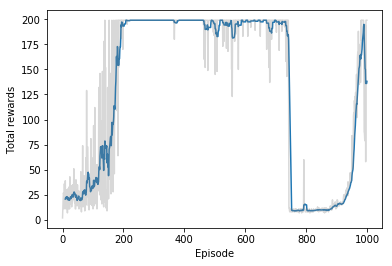

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

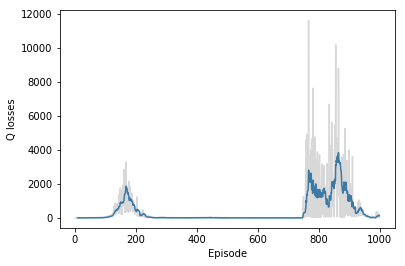

In [20]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

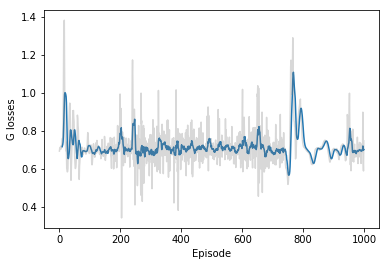

In [21]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

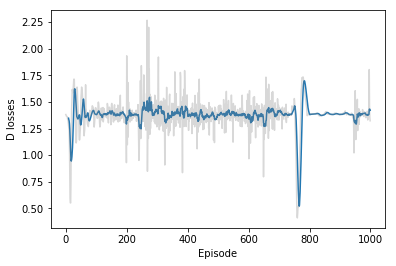

In [22]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
test_episodes = 5
test_max_steps = 2000
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

# Closing the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/QGAN-cartpole.ckpt


## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.